In [1]:
from collections import defaultdict
from datetime import datetime
from math import erf

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")

In [3]:
SD = 0.15
TAU = 1 / SD ** 2
SQRT2 = 2 ** 0.5

class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def __add__(self, other):
        return Normal(mu=self.mu + other.mu, sigma=(self.sigma ** 2 + other.sigma ** 2) ** 0.5)
    
    def __sub__(self, other):
        return Normal(mu=self.mu - other.mu, sigma=(self.sigma ** 2 + other.sigma ** 2) ** 0.5)
    
    def win_prob(self):
        return 0.5 - 0.5 * erf(-self.mu / (self.sigma * SQRT2))
    
    def __repr__(self):
        return "Normal (" + str(round(self.mu, 4)) + ", " + str(round(self.sigma, 4)) + ")"

class Rating:
    def __init__(self, prior_n=0, prior_mean=0):
        self.mu = prior_mean
        self.n = prior_n
        
        self.history = {
            "match": [],
            "obs": [],
            "mean": [],
            "sd_mean": [],
            "sd_obs": [],
            "sd_total": [],
        }
        
        self.streaks = [0, 0]
        
    def record(self, x = 0):
        self.history["match"].append(len(self.history["match"]))
        self.history["obs"].append(x)
        self.history["mean"].append(self.mean())
        self.history["sd_mean"].append(self.sd_mean())
        self.history["sd_obs"].append(self.sd_obs())
        self.history["sd_total"].append(self.sd_total())

    def add(self, x):
        self.record(x)
        self.mu = (self.mu * self.n + x) / (self.n + 1)
        
        mean, sd = self.mean(), self.sd_total()
        z_score = abs(mean - x) / sd
        if z_score > 1.5:
            self.n -= round(2 * z_score) / 2
            
        self.streaks[0] = self.streaks[0] + 1 if x > mean + sd / 3 else 0
        self.streaks[1] = self.streaks[1] + 1 if x < mean - sd / 3 else 0
        if max(self.streaks) > 2:
            self.n -= max(self.streaks) - 2
        
        self.n = max(1, self.n) + 0.5
        
    def mean(self):
        return self.mu
    
    def sd_mean(self):
        return self.sd_obs() / (self.n) ** 0.5
    
    def sd_obs(self):
        return max(self.mu * SD, 3)
    
    def sd_total(self):
        return (self.sd_mean() ** 2 + self.sd_obs() ** 2) ** 0.5
    
    def __repr__(self):
        return "Rating (" + \
            str(round(self.mean(), 4)) + ", " + \
            str(round(self.sd_mean(), 4)) + ", " + \
            str(round(self.sd_obs(), 4)) + ", " + \
            str(round(self.sd_total(), 4)) + ")"
    
    def mean_distrib(self):
        return Normal(self.mean(), self.sd_mean())
    
    def obs_distrib(self):
        return Normal(self.mean(), self.sd_total())
    
    def max_mean(self):
        return max([0] + self.history["mean"])
    
    def end_mean(self):
        return sum(self.history["mean"][-5:]) / 5
    
    @staticmethod
    def plot_ratings(ratings):
        fig, ax = plt.subplots(figsize=(9, 6))
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        for color, rating in zip(colors, ratings):
            ax.scatter(rating.history["match"], rating.history["obs"], label="Observations")
            ax.plot(rating.history["match"], rating.history["mean"], label="Bayesian")
            ax.fill_between(
                rating.history["match"], 
                [x - 2 * y for x, y in zip(rating.history["mean"], rating.history["sd_mean"])], 
                [x + 2 * y for x, y in zip(rating.history["mean"], rating.history["sd_mean"])],
                color=color, 
                alpha=0.4, 
                label="Mean CI"
            )

            ax.fill_between(
                rating.history["match"], 
                [x - 2 * y for x, y in zip(rating.history["mean"], rating.history["sd_total"])], 
                [x + 2 * y for x, y in zip(rating.history["mean"], rating.history["sd_total"])],
                color=color, 
                alpha=0.2, 
                label="Obs CI"
            )
        ax.legend()
        ax.grid()
        fig.show()

In [4]:
start_oprs = defaultdict(lambda: 13.8)
start_elos = defaultdict(lambda: 1500)
for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
    start_oprs[t.team] = t.opr_start
    start_elos[t.team] = t.elo_start

In [5]:
event_matches_df = matches_df[(matches_df.year == 2022) & (matches_df.comp_level == "qm") & (matches_df.status == "Completed")].sort_values(by=["time"])

display(event_matches_df)

,key,year,event,comp_level,set_number,match_number,status,red,red_elo_sum,red_opr_sum,...,blue_teleop_1,blue_teleop_2,blue_1,blue_2,blue_teleop,blue_endgame,blue_no_fouls,blue_fouls,blue_rp_1,blue_rp_2
154345,2022nhgrs_qm1,2022,2022nhgrs,qm,1,1,Completed,"7913,131,467",4617,29.69,...,2.0,0.0,4.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0
151040,2022miket_qm1,2022,2022miket,qm,1,1,Completed,"6067,1506,6091",4705,42.20,...,11.0,0.0,13.0,0.0,11.0,6.0,23.0,0.0,0.0,0.0
150436,2022midet_qm1,2022,2022midet,qm,1,1,Completed,"5090,2224,3414",4591,43.95,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
147382,2022flwp_qm1,2022,2022flwp,qm,1,1,Completed,"59,744,1523",4853,66.27,...,1.0,0.0,5.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0
147393,2022flwp_qm2,2022,2022flwp,qm,1,2,Completed,"5410,7652,3627",4427,44.91,...,0.0,0.0,6.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145947,2022carv_qm125,2022,2022carv,qm,1,125,Completed,"1700,870,3654",4952,85.25,...,35.0,0.0,55.0,0.0,35.0,0.0,61.0,0.0,1.0,0.0
157580,2022tur_qm123,2022,2022tur,qm,1,123,Completed,"5484,5985,2539",4947,81.38,...,41.0,0.0,53.0,0.0,41.0,10.0,69.0,4.0,1.0,0.0
157581,2022tur_qm124,2022,2022tur,qm,1,124,Completed,"3792,3061,1391",5122,116.21,...,82.0,0.0,114.0,0.0,82.0,34.0,154.0,4.0,1.0,1.0
157582,2022tur_qm125,2022,2022tur,qm,1,125,Completed,"8006,4003,649",4983,99.21,...,42.0,0.0,58.0,0.0,42.0,20.0,84.0,0.0,1.0,1.0


In [6]:
data = []

mean = 13
ratings = defaultdict(lambda: Rating(prior_n=1, prior_mean=mean))
auto_ratings = defaultdict(lambda: Rating(prior_n=1, prior_mean=mean / 3))
teleop_ratings = defaultdict(lambda: Rating(prior_n=1, prior_mean=mean / 3))
endgame_ratings = defaultdict(lambda: Rating(prior_n=1, prior_mean=mean / 3))
for t in start_oprs:
    ratings[t] = Rating(prior_n=1, prior_mean=start_oprs[t])
    auto_ratings[t] = Rating(prior_n=1, prior_mean=start_oprs[t] / 3)
    teleop_ratings[t] = Rating(prior_n=1, prior_mean=start_oprs[t] / 3)
    endgame_ratings[t] = Rating(prior_n=1, prior_mean=start_oprs[t] / 3)

count, acc, mse = 0, 0, 0
event_count, event_acc, event_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    red_teams = [int(x) for x in match.red.split(",")]
    blue_teams = [int(x) for x in match.blue.split(",")]
    
    red_distribs = []
    for r in red_teams:
        a = auto_ratings[r].obs_distrib()
        t = teleop_ratings[r].obs_distrib()
        e = endgame_ratings[r].obs_distrib()
        red_distribs.append(Normal(a.mu + t.mu + e.mu, a.sigma + t.sigma + e.sigma))
    red_total_distrib = sum(red_distribs, Normal(0, 0))
    
    blue_distribs = []
    for b in blue_teams:
        a = auto_ratings[b].obs_distrib()
        t = teleop_ratings[b].obs_distrib()
        e = endgame_ratings[b].obs_distrib()
        blue_distribs.append(Normal(a.mu + t.mu + e.mu, a.sigma + t.sigma + e.sigma))
    blue_total_distrib = sum(blue_distribs, Normal(0, 0))
    
    red_distrib = sum((ratings[r].obs_distrib() for r in red_teams), Normal(0, 0))
    blue_distrib = sum((ratings[b].obs_distrib() for b in blue_teams), Normal(0, 0))
    
    win_prob = (red_total_distrib - blue_total_distrib).win_prob()
    
    data.append({
        "red_pred": red_total_distrib.mu,
        "red_actual": match.red_no_fouls,
        "blue_pred": blue_total_distrib.mu,
        "blue_actual": match.blue_no_fouls,
        "win_pred": win_prob,
        "win_actual": match.red_score > match.blue_score,
    })
    
    for score, teams, ratings_dict in [
        (match.red_no_fouls, red_teams, ratings),
        (match.blue_no_fouls, blue_teams, ratings),
        (match.red_auto, red_teams, auto_ratings),
        (match.blue_auto, blue_teams, auto_ratings),
        (match.red_teleop, red_teams, teleop_ratings),
        (match.blue_teleop, blue_teams, teleop_ratings),
        (match.red_endgame, red_teams, endgame_ratings),
        (match.blue_endgame, blue_teams, endgame_ratings),
    ]:
        means = [ratings_dict[t].mean() for t in teams]
        error = score / sum(means)
        for t, mean in zip(teams, means):
            ratings_dict[t].add(mean * error)
    
    count += 1
    acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
    mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"]:
        # print(match.key)
        # print(red_total_distrib, blue_total_distrib, win_prob)
        # print(match.red_score, match.blue_score)
        # print()
        event_count += 1
        event_acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        event_mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
print(count, acc / count, mse / count)
print(event_count, event_acc / event_count, event_mse / event_count)

12048 0.7585491367861886 0.15939079244834128
756 0.7592592592592593 0.1566178245191111


In [7]:
elo_count, elo_acc, elo_mse = 0, 0, 0
event_elo_count, event_elo_acc, event_elo_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    elo_win_prob = match.opr_win_prob
    elo_count += 1
    elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
    elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"]:
        event_elo_count += 1
        event_elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
        event_elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    
print(elo_count, elo_acc / elo_count, elo_mse / elo_count)
print(event_elo_count, event_elo_acc / event_elo_count, event_elo_mse / event_elo_count)

12048 0.7621181938911022 0.15756212934262956
756 0.7791005291005291 0.1533497148015875


62.770817188664275
16.285693178351742 33.03934955965786 14.581648194775832
63.90669093278543


<IPython.core.display.Javascript object>


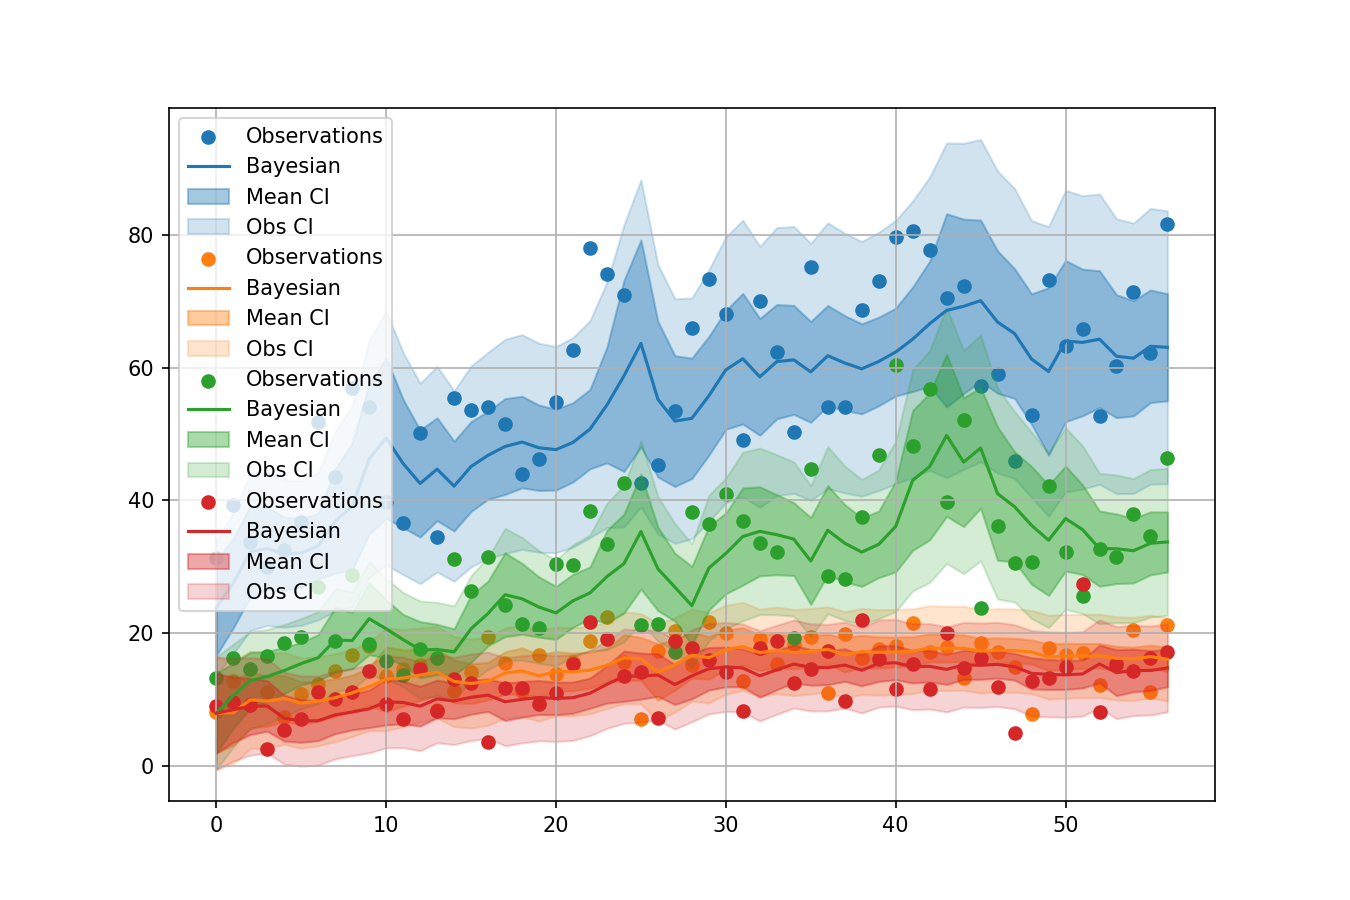

In [8]:
t = 27
print(ratings[t].end_mean())
print(auto_ratings[t].end_mean(), teleop_ratings[t].end_mean(), endgame_ratings[t].end_mean())
print(auto_ratings[t].end_mean() + teleop_ratings[t].end_mean() + endgame_ratings[t].end_mean())
Rating.plot_ratings([ratings[t], auto_ratings[t], teleop_ratings[t], endgame_ratings[t]])

In [9]:
final_ratings = {}
for t in ratings:
    final_ratings[t] = auto_ratings[t].end_mean() + teleop_ratings[t].end_mean() + endgame_ratings[t].end_mean()
sorted(final_ratings.items(), key=lambda x:-x[1])[:10]

[(1678, 83.06419686493874),
 (1690, 72.83551067657082),
 (1323, 71.44420971390778),
 (254, 71.14556089301632),
 (67, 67.25974543294902),
 (118, 65.80620685537275),
 (973, 65.01428222690991),
 (1577, 64.98608961823314),
 (27, 63.90669093278543),
 (2910, 62.66512104104221)]

<IPython.core.display.Javascript object>


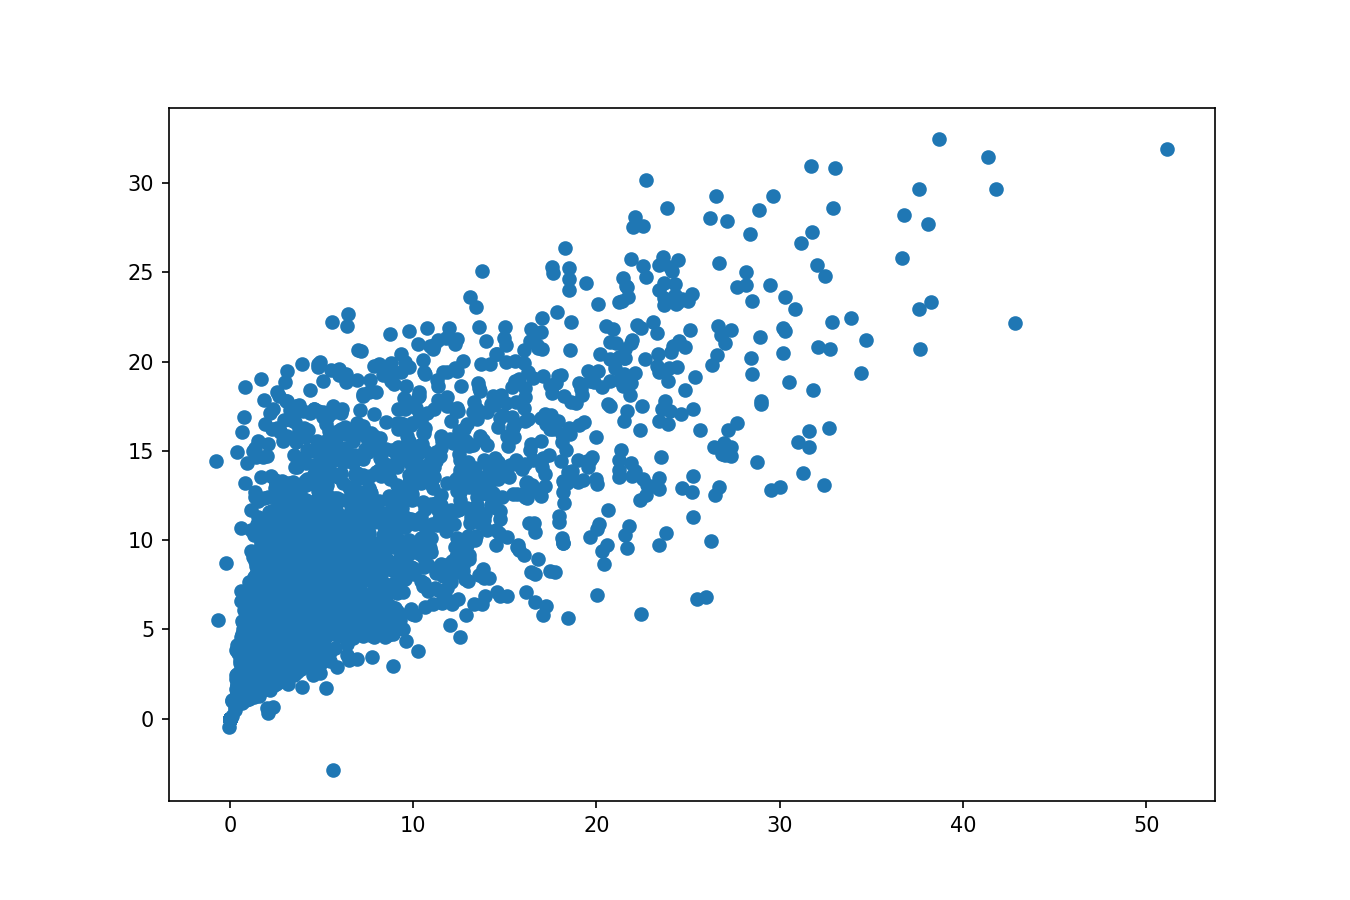

In [10]:
auto_list = [x.end_mean() for x in auto_ratings.values()]
teleop_list = [x.end_mean() for x in teleop_ratings.values()]
auto_teleop_list = [x + y for x, y in zip(auto_list, teleop_list)]
endgame_list = [x.end_mean() for x in endgame_ratings.values()]
auto_endgame_list = [x + y for x, y in zip(auto_list, endgame_list)]
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(teleop_list, auto_endgame_list)
fig.show()

In [11]:
data_df = pd.DataFrame(data)
display(data_df.sort_values(by=["win_pred"]))

,red_pred,red_actual,blue_pred,blue_actual,win_pred,win_actual
11441,34.092063,31.0,170.399572,120.0,1.044459e-07,False
5848,18.032701,14.0,131.540810,136.0,4.287519e-06,False
11885,26.308786,54.0,136.369903,153.0,7.843323e-06,False
7607,29.783792,24.0,138.578811,137.0,2.199123e-05,False
6488,29.910251,20.0,140.617583,109.0,5.142329e-05,False
...,...,...,...,...,...,...
6752,122.661089,93.0,29.153630,47.0,9.999151e-01,True
6523,114.618428,113.0,20.920931,11.0,9.999211e-01,True
10604,155.597046,168.0,38.418586,44.0,9.999926e-01,True
7774,154.879200,145.0,32.483465,21.0,9.999968e-01,True


<IPython.core.display.Javascript object>


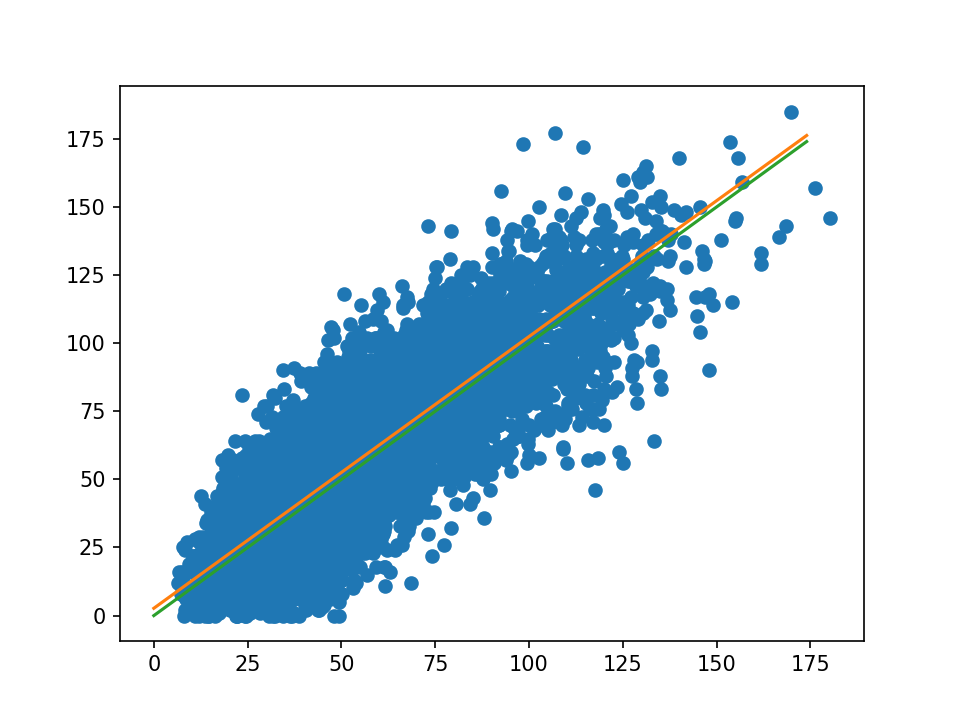

0.9973920394712248 2.6870884112596833


In [12]:
fig, ax = plt.subplots()
ax.scatter(data_df.red_pred, data_df.red_actual)
m, b = np.polyfit(data_df.red_pred, data_df.red_actual, 1)
print(m, b)
ax.plot([x for x in range(175)], [x for x in range(175)], color="tab:green")
ax.plot([x for x in range(175)], [m * x + b for x in range(175)], color="tab:orange")
fig.show()

<IPython.core.display.Javascript object>


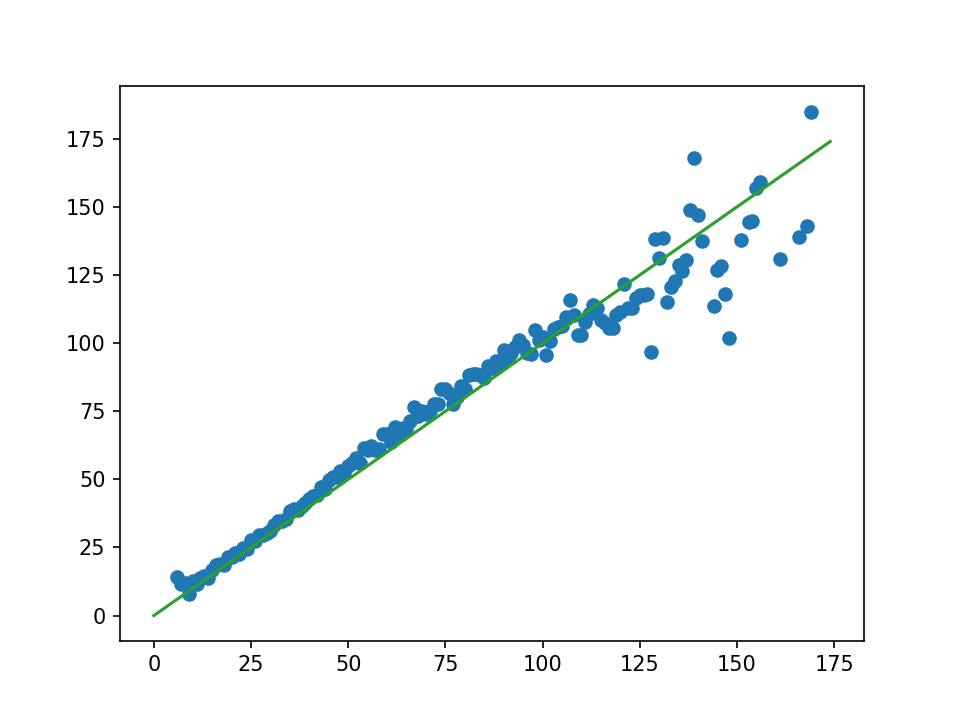

In [13]:
fig, ax = plt.subplots()

x, y = [], []
for i in range(175):
    subset_df = data_df[(data_df.red_pred > i) & (data_df.red_pred < i + 1)]
    actual = subset_df.red_actual.mean()
    x, y = x + [i], y + [actual]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()

<IPython.core.display.Javascript object>


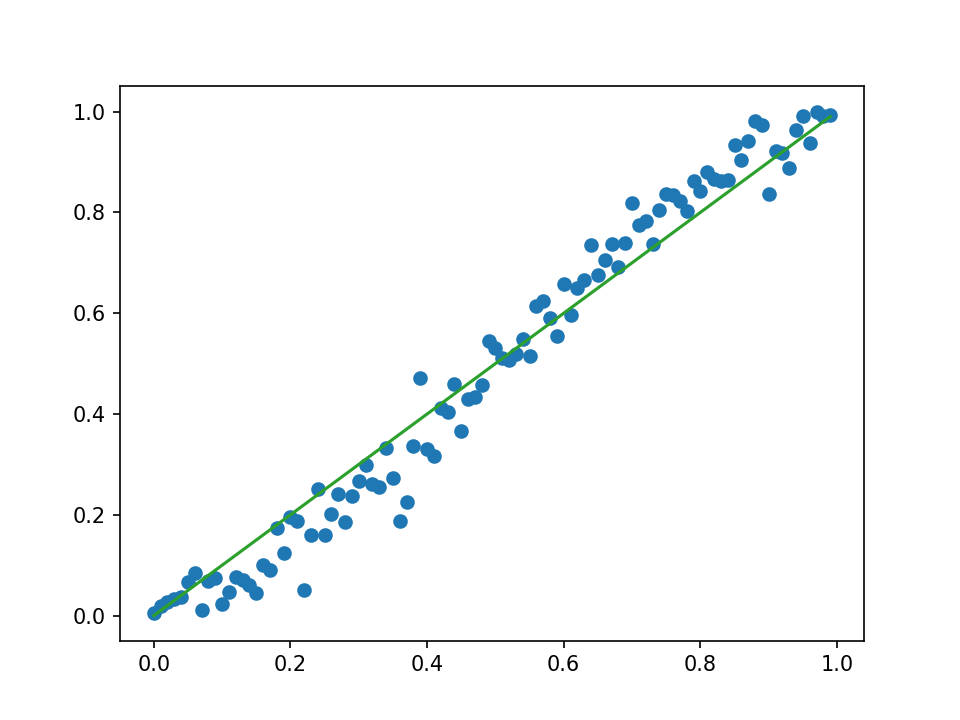

In [14]:
fig, ax = plt.subplots()

x, y = [], []
for i in range(100):
    percent = i / 100
    subset_df = data_df[(data_df.win_pred > percent) & (data_df.win_pred < percent + 0.01)]
    actual_percent = subset_df.win_actual.mean()
    x, y = x + [percent], y + [actual_percent]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()